# HySwash: A hybrid method for nearshore wave processes

Table of Contents
* [1. Clustering and selection method MDA](#1.-Clustering-and-selection-method-MDA)
	* [1.1 Data preprocessing](#1.1-Data-preprocessing)
	* [1.2 MDA algorithm](#1.2-MDA-algorithm)<br><br>
    
* [2. Numerical model SWASH](#2.-Numerical-model-SWASH)
	* [2.1 Data preprocessing](#2.1-Data-preprocessing)   
		* [2.1.1 Cross-shore profile](#2.1.1-Cross-shore-profile)
		* [2.1.2 Friction](#2.1.2-Friction)     
		* [2.1.3 Vegetation](#2.1.3-Vegetation) 
	* [2.2. Boundary conditions](#2.2-Boundary-conditions)
		* [2.2.1 Sea state](#2.2.1-Sea-state)
		* [2.2.2 Wind](#2.2.2-Wind)
	* [2.3. Run](#2.3-Run)
	* [2.4. Data Postprocessing](#2.4.-Data-Postprocessing)<br><br>
    
* [3. Time series reconstruction RBF](#3.-Time-series-reconstruction-RBF)
<br><br>

In [4]:
# Import python libraries
# basic
import os
import sys
import os.path as op

# common
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML
mpl.rcParams['figure.dpi'] = 120

# addpath to bluemath modules
sys.path.insert(0, op.join(os.getcwd(), '..', '..'))

# wrap_swash modules
from wrap_swash.wswash.wrap import SwashProject, SwashWrap, SwashInput
from wrap_swash.wswash.postprocessor import Postprocessor
from wrap_swash.wswash.plots import SwashPlot
from wrap_swash.wswash.io import SwashIO
from wrap_swash.wswash.profiles import reef

# statistical_toolkit  modules:
from scipy.stats import qmc 
from statistical_toolkit.bluemathtk.MDA import *
from statistical_toolkit.bluemathtk.PCA import *
from hyswash.lib.output_extract import *
from hyswash.lib.waves import series_TMA
from hyswash.lib.reconstruction import RBF_Reconstruction_singular, RBF_Reconstruction_spatial


ModuleNotFoundError: No module named 'plotly'

In [5]:
pip install plotly


  Using cached plotly-5.19.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
Using cached plotly-5.19.0-py3-none-any.whl (15.7 MB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


## Paths & Initialization Project

In [2]:
# Create the project directory 
p_proj = op.abspath(op.join(os.getcwd(), '..', 'projects')) # swash projects main directory
n_proj = 'test'                                             # project name

p_data = op.join(p_proj, n_proj, 'data')
if not os.path.exists(p_data):   os.makedirs(p_data)

p_dataset = op.join(p_data, 'dataset.pkl')
p_subset = op.join(p_data, 'subset.pkl')

p_config = op.join(p_data, 'config')
if not os.path.exists(p_config):   os.mkdir(p_config)


In [3]:
# Initialize the project
sp = SwashProject(p_proj, n_proj)
sw = SwashWrap(sp)
si = SwashIO(sp)
sm = SwashPlot(sp)

In [4]:
# Set the simulation period and grid resolution
sp.tendc = 1800                          # simulation period (SEC)
sp.warmup = 0.15 * sp.tendc              # spin-up time (s) (default 15%)

## Hydraulic Boundary Conditions

### Historical

In [5]:
# Load wind-sea states
waves = xr.open_dataset(op.join(p_data, 'waves_csiro_demo.nc'))

In [6]:
# Dataset 
waves = waves.squeeze()
df_dataset = pd.DataFrame(
    {
        'time': waves.time.values,
        'hs': waves.hs.values, 
        'tp': waves.t.values, 
        'w': np.sqrt(waves.U10.values**2 + waves.V10.values**2),
        'wdir': waves.dir.values,
        'sl':waves.wl.values / 100
    }
)

### Synthetic: Latine Sampling Hypercube

In [7]:
# name of dimensions
name_dims = ['Hs', 'Hs_L0', 'WL']

# upper and lower bounds
low_bounds = [0.5,    0.005,   0] 
upp_bounds =[   3,     0.05,   2] 

# number of samples to obtain
n_dims = len(name_dims)
n_samples = 10000 


In [8]:
# LHS execution
sampler = qmc.LatinHypercube(d = n_dims, seed=1)
dataset = sampler.random(n = n_samples)
dataset = qmc.scale(dataset, low_bounds, upp_bounds)

# convert to dataframe
df_dataset = pd.DataFrame(data=dataset, columns=name_dims)


> Plot dataset

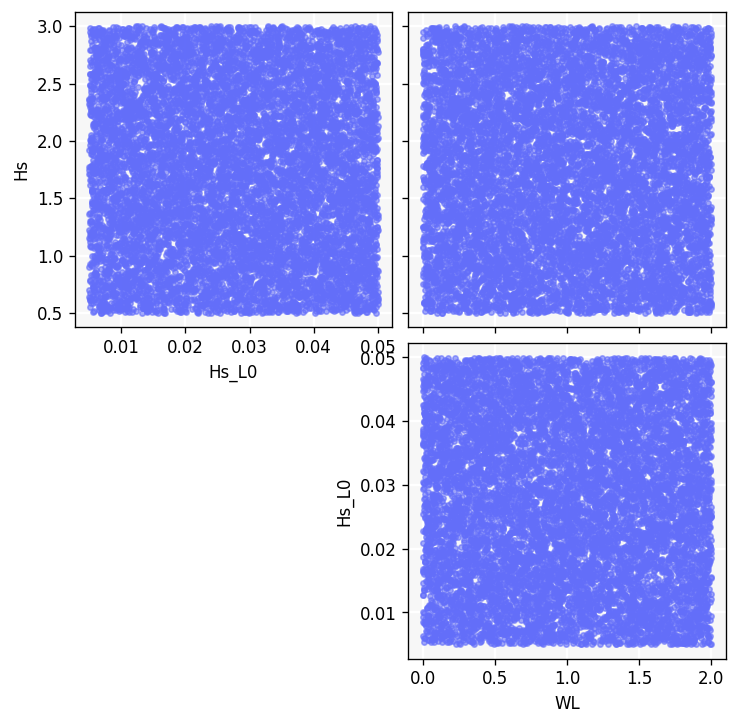

In [9]:
dims = ['Hs', 'Hs_L0', 'WL']

fig = scatter_mda([df_dataset[dims]], names = dims, figsize=(7,7))

<br>

## Clustering & Selection Method MDA

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v1}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.  


### MDA algorithm

In [10]:
# subset, scalar and directional indexes
ix_scalar = [0, 1, 2]      
ix_directional = []        
n_subset = 5

# MDA algorithm
out = MaxDiss_Simplified_NoThreshold(
    df_dataset[name_dims].values, 
    n_subset, 
    ix_scalar, ix_directional
)

df_subset = pd.DataFrame(data=out, columns=name_dims)
df_subset



MaxDiss waves parameters: 10000 --> 5

   MDA centroids: 5/5



Hs     Hs_L0        WL
0  2.999787  0.012230  1.816859
1  0.513937  0.046528  0.017673
2  0.507842  0.027170  1.982941
3  1.747350  0.005750  0.041088
4  2.986667  0.046966  0.452214

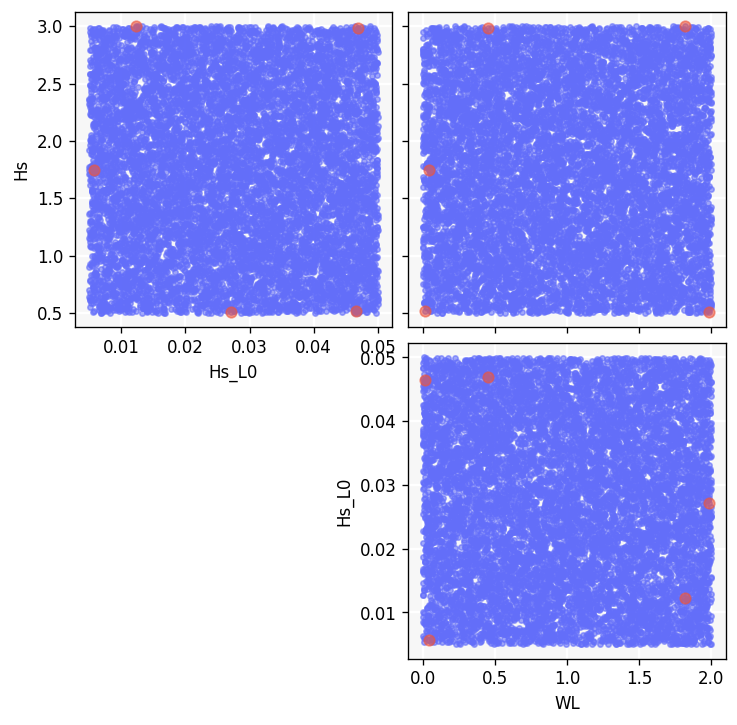

In [11]:
# Plot subset-dataset
dims = ['Hs', 'Hs_L0', 'WL']
fig = scatter_mda([df_dataset[dims], df_subset[dims]], names =dims, figsize=(7,7), ss=[10, 40])

## Numerical model SWASH


In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region.

### Cross-shore profile


Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible kh < 5. As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. 
 
* `dxL`  : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). 

* `dxinp`: The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible. 


Land points are defined as negative while wet points are defined as positive.
    

#### Bathymetry from File

{'fontsize': 15, 'figure_width': 6.4, 'figure_height': 2.1333333333333333}


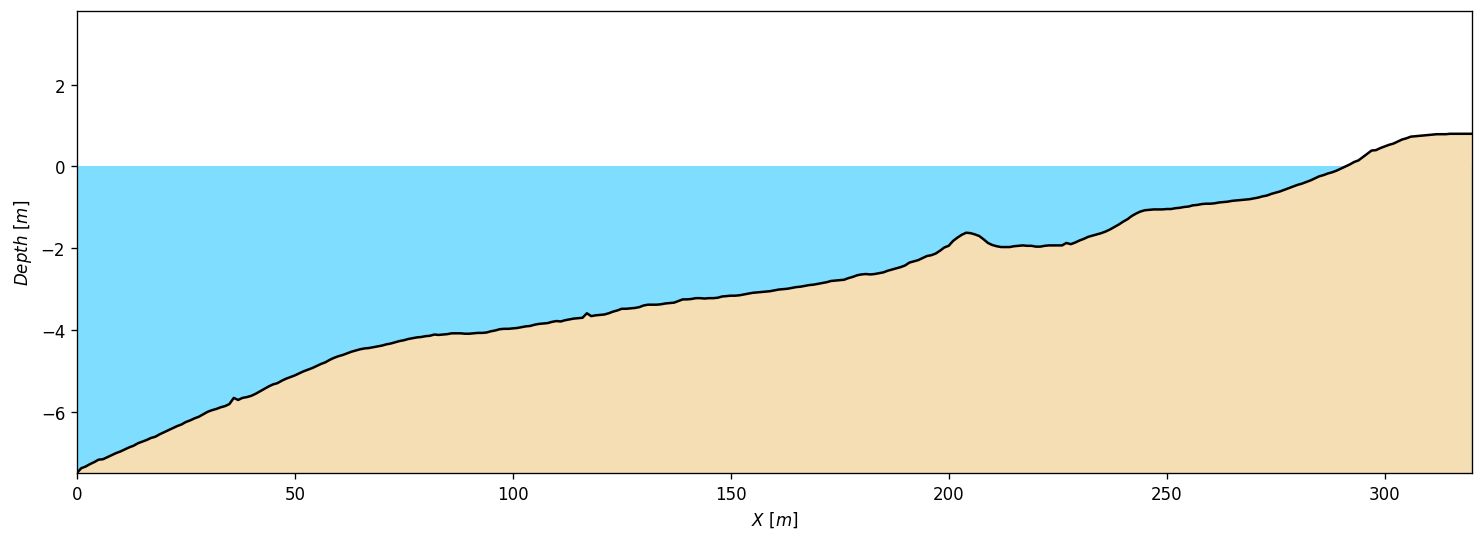

In [12]:
# Import depth FILE
sp.dxL = 30                                                     # nº nodes per wavelength
sp.dxinp = 1                                                    # bathymetry spacing resolution (m)

depth = np.loadtxt(op.join(p_data, 'depth.bot'))        # depth file path
sp.depth = depth 

fig = sm.plot_depthfile() 

fig.savefig(op.join(p_config, 'coral_reef_profile.png'), dpi=600)
np.savetxt(op.join(p_config, 'depth.txt'), depth)

#### Coral-reef Profile

In [13]:
sp.b_grid.dx = 1            # bathymetry mesh resolution at x axes (m)
sp.dxL = 40                 # nº nodes per wavelength
sp.dxinp = 1                # bathymetry spacing resolution (m
sp.dyinp = 1

{'fontsize': 15, 'figure_width': 6.4, 'figure_height': 2.1333333333333333}


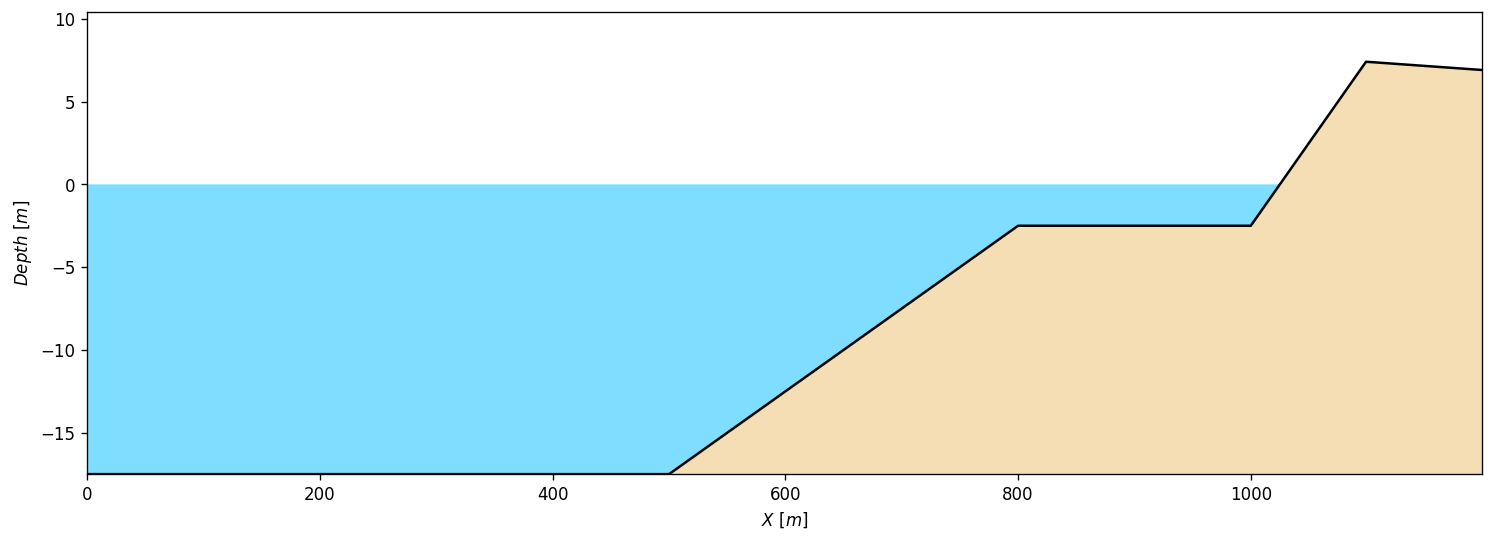

In [14]:
h0 = 15                     # offshore depth (m)
Slope1 = 0.05               # fore shore slope
Slope2 = 0.1                # inner shore slope
Wreef = 200                 # reef bed width (m)
Wfore = 500                 # flume length before fore toe (m)
bCrest = 10                 # beach heigh (m)
emsl = 2.5                  # mean sea level (m)

depth = reef(sp.b_grid.dx, h0, Slope1, Slope2, Wreef, Wfore, bCrest, emsl)

sp.set_depth(depth, sp.dxinp, sp.dyinp)

fig = sm.plot_depthfile()

fig.savefig(op.join(p_config, 'coral_reef_profile.png'), dpi=600)
np.savetxt(op.join(p_config, 'depth.txt'), depth)

#### Friction


With this option the user can activate the bottom friction controlled by the Manning formula. As the friction coefficient may vary over the computational region, the friction data can be read from file or defined by specifyng the start and end point along it is defined the frictional area (e.g. reef). 
    

In [15]:
# Set a constant friction between two points of the profile 
sp.friction_file = False
sp.friction = True
sp.Cf = 0.01                       # manning frictional coefficient  (m^-1/3 s)
sp.cf_ini = 0                      # first point along the profile 
sp.cf_fin = 800                    # last point along the profile 

### Boundary conditions

The boundaries of the computational grid in SWASH are either land, beach or water. The wave condition is imposed on the west boundary of the computational domain, so that the wave propagation is pointing eastward. To simulate entering waves without some reflections at the wavemaker boundary, a weakly-reflective boundary condition allowing outgoing waves is adopted. For this test case, a time series synthesized from parametric information (wave height, period, etc.) will be given as wavemaker. Here, the wavemaker must be defined as irregular unidirectional waves by means of 1D spectrum. Both the initial water level and velocity components are set to zero.


#### Sea state

In [16]:
# Create wave series and save 'waves.bnd' file
sp.deltat = 1              # delta time over which the wave series is defined

sp.non_hydrostatic = True  # True or False
sp.vert = 1                # vertical layers
sp.delttbl = 1             # time between output fields (s)

In [17]:
df_subset['H'] = df_subset['Hs']
df_subset['T'] = np.sqrt((df_subset['Hs'].values * 2 * np.pi) / (9.806 * df_subset['Hs_L0']))
df_subset['gamma'] = 2
df_subset['warmup'] = sp.warmup
df_subset['deltat'] = sp.deltat
df_subset['tendc'] = sp.tendc


Input waves definition at `waves.py`: <br>
series_regular_monochromatic, series_regular_bichromatic <br>
series_Jonswap, series_TMA <br>
series_Jonswap_bimiodal, series_TMA_bimodal

In [18]:
# Create list of swash wrappers
list_wrap = []
for iw, waves in df_subset.iterrows():
    
    sys.stdout.write('\rCase {0}'.format(iw))
    sys.stdout.flush()
    
    series = series_TMA(waves, depth[0])
    
    si = SwashInput() 
    si.waves_parameters = waves
    si.waves_series = series
    
    list_wrap.append(si)
    

Case 4

In [19]:
sw = SwashWrap(sp)
waves = sw.build_cases(list_wrap)

#### Wind

The user can optionally specify wind speed, direction and wind drag assuming constant values in the domain. As the test case is using cartesian coordinates, please set the direction where the wind cames from.

In [20]:
# Define wind parameters
sp.wind = False           # wind direction at 10 m height (º)
sp.Ca = 0.0026           # dimensionless coefficient (default 0.002)

### Run cases


In the following, a series of predefined options have been choosen: <br></span>

* Grid resolution is determined through a number of points per wavelength criteria: Courant number for numerical stability, number of points per wavelength, and manual upper and lower limits for grid cell sizes

* The default value for the maximun wave breaking steepness parameter is $ \alpha = 0.6$

* For high, nonlinear waves, or wave interaction with structures with steep slopes (e.g. jetties, quays), a Courant number of 0.5 is advised. Here, a dynamically adjusted time step controlled by a Courant number range of (0.1 - 0.5) is implemented

User parametes:

* `Nonhydrostatic` : to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant 
* `vert` : this command set the number of vertical layers in case that the run will be in multi-layered mode 


In [21]:
# Run cases
sw.run_cases()

### Data Postprocessing

Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.


In [21]:
# convert raw SWASH output to netcdf files
sw.output_files()

SWASH CASE: /media/administrador/Disco/Documents/Bluemath/wrap-hyswash/hyswash/projects/test/0000 POSTPROCESSED
SWASH CASE: /media/administrador/Disco/Documents/Bluemath/wrap-hyswash/hyswash/projects/test/0001 POSTPROCESSED
SWASH CASE: /media/administrador/Disco/Documents/Bluemath/wrap-hyswash/hyswash/projects/test/0002 POSTPROCESSED
SWASH CASE: /media/administrador/Disco/Documents/Bluemath/wrap-hyswash/hyswash/projects/test/0003 POSTPROCESSED
SWASH CASE: /media/administrador/Disco/Documents/Bluemath/wrap-hyswash/hyswash/projects/test/0004 POSTPROCESSED


In [21]:
# define variables to compute
output_vars = ['Ru2', 'Msetup', 'RuDist', 'Hrms', 'Hfreqs']

In [22]:
# Set 'run_post' to True to run postprocessing of each case
sdp = Postprocessor(sp, si, sw, output_vars, run_post=False)
sdp.ds_output

<xarray.Dataset> Size: 722kB
Dimensions:  (Tsec: 8841, Xp: 1200, case_id: 5)
Coordinates:
  * Tsec     (Tsec) float64 71kB 270.0 270.0 270.0 ... 2.069e+03 2.07e+03
  * Xp       (Xp) float64 10kB 0.0 1.0 2.0 3.0 ... 1.197e+03 1.198e+03 1.199e+03
  * case_id  (case_id) float64 40B 0.0 1.0 2.0 3.0 4.0
    Yp       float64 8B 0.0
Data variables:
    Ru2      (case_id) float64 40B 2.933 0.3699 0.2072 1.651 2.059
    Runlev   (case_id, Tsec) float64 354kB nan nan 0.6667 nan ... nan nan nan
    Msetup   (case_id, Xp) float64 48kB 0.01378 0.01101 0.007009 ... 6.459 6.458
    Hrms     (case_id, Xp) float64 48kB 8.825 8.948 9.174 9.407 ... nan nan nan
    Hs       (case_id, Xp) float64 48kB 3.327 3.302 3.254 ... 3.243e-15 9.73e-15
    Hss      (case_id, Xp) float64 48kB 3.292 3.267 ... 1.176e-18 3.529e-18
    ig       (case_id, Xp) float64 48kB 0.4751 0.4758 ... 3.243e-15 9.73e-15
    Hvlf     (case_id, Xp) float64 48kB 0.0627 0.06235 ... 3.036e-15 9.108e-15

#### Sea Surface Video

In [23]:
case = 4
ani = sm.animate_case_propagation(sp, case, tini=100, tend=200, tstep=4, figsize=(15,5))
HTML(ani.to_jshtml())


## Reconstruction - Interpolation


The reconstruction of the time series of wave parameters in the position of the buoy is carried out by an interpolation technique based on radial basis functions (RBF), a scheme wich is very convenient for scatter and multivariate data. The RBF approximation has been applied successfully in many fields, usually with better results than other interpolation methods (Hardy, 1990).
    
Suppose that $f=f(x)$ is the real-valued function that we want to approximate. We are given M scattered data points $\{x_1,..., x_M\}$ of dimension $\textit{n}$ and the associated real function values $\{f_1, ..., f_M\}$, being $f_i = f(x_j), j = 1,...,M$. The RBF interpolation method consists of a weighted sum of radially symmetric basic functions located at the data points. The approximation function is assumed to be of the form:

$RBF(x) = p(x) + \sum\limits_{j=1}^M a_j\Phi{\large (}{\large \parallel}{x - x_j}{\large \parallel}{\large )}$&nbsp;&nbsp;&nbsp;&nbsp;

### Singular Reconstruction

In [ ]:
var = ['Ru2']

ix_scalar_subset = [0, 1, 2]
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []

In [ ]:
# RBF reconstruction
df_output = RBF_Reconstruction_singular(
    sdp, var, dims, df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target)


In [ ]:
fig = scatter_color(df_dataset, df_output, dims, var, figsize=(7,7), vmin=None, vmax=None, cmap='jet')

### Spatial Reconstruction

In [25]:
var = ['Msetup']                 # variable to reconstruct
X_max = 1000                     # maximum spatial X to consider for PCA
variance = 99.8                  # maximum variance to explain

ix_scalar_subset = [0, 1, 2]    
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []


Range sigma 0.0010-0.1000 - Opt sigma 0.0924
Range sigma 0.0010-0.1000 - Opt sigma 0.0856
Range sigma 0.0010-0.1000 - Opt sigma 0.0924


In [ ]:
# Compute PCA and apply RBF recosntruction
xds_PCA, ds_output = RBF_Reconstruction_spatial(
    sdp, var, dims, df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target, variance, X_max)


In [ ]:
ds_output

> Plot PCA results: EOFs + PCs

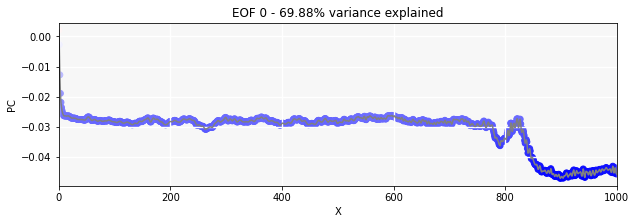

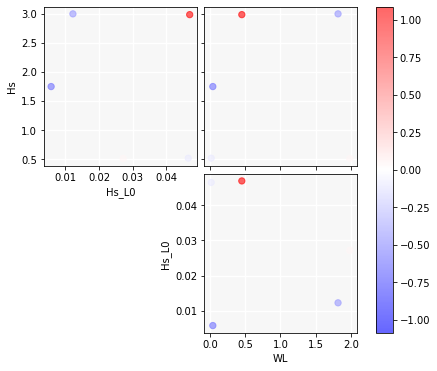

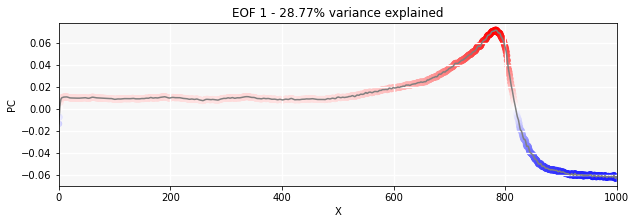

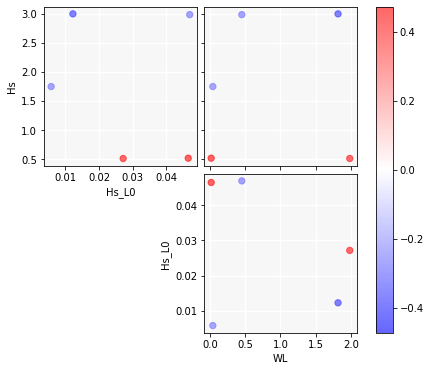

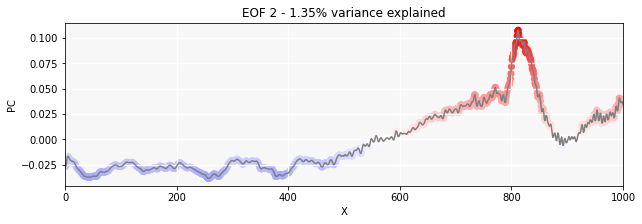

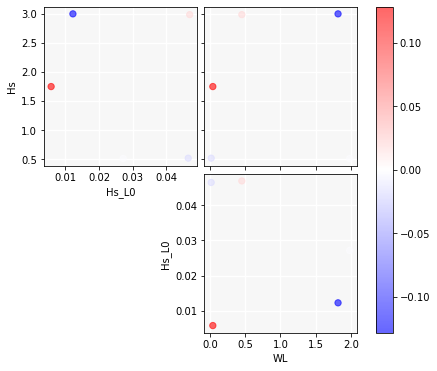

In [37]:
plot_PCA(xds_PCA, df_subset, dims, figsize1=(6+1,6), figsize2=(10,3))

In [38]:
ds_output

<xarray.Dataset>
Dimensions:  (case: 10000, Xp: 1001)
Coordinates:
  * case     (case) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
  * Xp       (Xp) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
Data variables:
    Msetup   (case, Xp) float64 0.006159 0.005253 0.003209 ... 0.04957 0.0494